In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.special import exp10
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.compose import make_column_transformer, TransformedTargetRegressor
from sklearn.pipeline import make_pipeline

SEED = 20221125

In [2]:
def keep_relevant_cols(data: pd.DataFrame)->pd.DataFrame:
    result = data.copy(deep=True)
    # we remove the columns that with low variance and high missing value 
    relevant_cols = [
        "host_since",
        "host_response_time",
        "host_response_rate",
        "host_acceptance_rate",
        "host_is_superhost",
        "host_total_listings_count",
        "host_identity_verified",
        "calculated_host_listings_count",
        "calculated_host_listings_count_entire_homes",
        "calculated_host_listings_count_private_rooms",
        "calculated_host_listings_count_shared_rooms",
        "neighbourhood_cleansed",
        "latitude",
        "longitude",
        "room_type",
        "accommodates",
        "bathrooms_text",
        "bedrooms",
        "beds",
        "amenities",
        "minimum_nights",
        "maximum_nights",
        "availability_365",
        "number_of_reviews",
        "number_of_reviews_ltm",
        "review_scores_rating",
        "review_scores_accuracy",
        "review_scores_cleanliness",
        "review_scores_checkin",
        "review_scores_communication",
        "review_scores_location",
        "review_scores_value",
        "instant_bookable",
        "price"
    ]
    return result[relevant_cols]
    

In [3]:
def create_dummy(data: pd.DataFrame)->pd.DataFrame:
    """
    Doing one-hot encoding for all categorical variable in the dataset 
    And concat with the original dataset
    """
    cat_vars=[
        "host_response_time",
        "host_identity_verified",
        "neighbourhood_cleansed",
        "room_type",
        "instant_bookable"
    ]
    result = data.copy(deep=True)
    dummy_dfs = []
    for col in cat_vars:
        tmp = pd.get_dummies(result[col], prefix=col, drop_first=True)
        new_cols = []
        for tmp_col in tmp.columns:
            new_cols.append("_".join(tmp_col.split()))
        tmp.columns = new_cols
        dummy_dfs.append(tmp)
        del result[col]
    result = pd.concat([result]+dummy_dfs, axis=1)
    return result

In [4]:
def create_dependant_vairable(data: pd.DataFrame)->pd.DataFrame:
    """
    Give label for the price column
    if the price > median, give '1' label other wise '0' label
    """
    result = data.copy(deep=True)
    result["price_label"], price_range = pd.qcut(result.price, q=2, labels=False, retbins=True)
    print(f"splitting the listing based on price range: {price_range}")
    return result

In [5]:
def remove_outlier(data: pd.DataFrame)->pd.DataFrame:
    
    result = data.copy(deep=True)
    # First tranform the price by applying log 
    log10_price = np.log10(result.price, where=(result.price>0))
    # calculate summary statistics
    log10_price_mean, log10_price_std = np.mean(log10_price), np.std(log10_price)
    # identify outliers
    cut_off = log10_price_std * 3
    lower, upper = log10_price_mean - cut_off, log10_price_mean + cut_off

    return result[(log10_price>lower)&(log10_price<upper)].reset_index(drop=True)

In [6]:
def dist(l_i, w_i, l_j, w_j):
    """
    given longitude(l) and latitude(w) of station i and listing j ,
    find the distance between the two
    """
    return np.round(111*1000*np.sqrt(((l_i - l_j )*np.cos(w_i))**2 +(w_i - w_j)**2))
    
def find_nearest_mtr(listing, mtr_loc_df: pd.DataFrame):
    listing_long, listing_lat = listing.longitude, listing.latitude
    best_dist = np.Infinity
    nearest_mtr = None
    for row in mtr_loc_df.itertuples():
        tmp = dist(row.mtr_long, row.mtr_lat, listing_long, listing_lat)
        if tmp < best_dist:
            best_dist = tmp
            nearest_mtr = row.station_name
    return nearest_mtr, best_dist

def add_distance_var(data: pd.DataFrame)->pd.DataFrame:
    result = data.copy(deep=True)
    mtr_loc_df = pd.read_csv("mtr-location.csv")
    nearest_mtr_df = result[["latitude", "longitude"]].apply(find_nearest_mtr, args=(mtr_loc_df,),axis=1)
    result = pd.concat([
            result,
            pd.DataFrame(list(nearest_mtr_df), columns=["nearest_mtr", "mtr_dist"])
        ], axis=1)
    return result

In [7]:
def preprocess_data(data: pd.DataFrame)->pd.DataFrame:
    """
    Clean and transform the panda dataframe
    """
    # keep only relevant columns
    result = keep_relevant_cols(data)

    # convert price to number
    result['price'] = result['price'].str\
        .replace("[$, ]", "", regex=True)\
        .astype("float")

    # remove rows where price == nan
    result = result.dropna(subset=['price'])

    # turn the percentage string into float 
    result["host_response_rate"] = result.host_response_rate.str.replace("%", "").astype(float)/100
    result["host_acceptance_rate"] = result.host_acceptance_rate.str.replace("%", "").astype(float)/100

    # translate half-bath room into 0.5 bathrooms
    result["bathrooms_text"] = result.bathrooms_text.str.replace("[Hh]alf", "0.5", regex=True)
    
    # capture the # of bathrooms 
    result["bathrooms"] = result.bathrooms_text.str.extract(r"([\d.]+)").astype(float)
    del result["bathrooms_text"]

    # Calculate how many year of experience for the host 
    result["host_exp"] = (pd.Timestamp.now() - pd.to_datetime(result.host_since))\
                        .apply(lambda x: round(x.days/365))
    del result["host_since"]

    # Count the total # of amenities of the listing 
    result["total_amenities"] = result.amenities.apply(lambda x: x.__len__())
    del result["amenities"]

    # fill missing values for review score columns
    review_scores_columns = [
        'review_scores_rating', 
        'review_scores_accuracy', 
        'review_scores_cleanliness',
        'review_scores_checkin', 
        'review_scores_communication', 
        'review_scores_location',
        'review_scores_value'            
    ]

    for column in review_scores_columns:
        result[column].fillna(result[column].mean(), inplace = True)

    # fill in missing values for other columns 
    result['bedrooms'] = result['bedrooms'].fillna(result['bedrooms'].mode()[0])
    result['beds'] = result['beds'].fillna(result['beds'].mode()[0])
    result['bathrooms'] = result['beds'].fillna(result['beds'].mode()[0])
    result['host_response_time'] = result['host_response_time'].fillna(result['host_response_time'].mode()[0])
    result['host_is_superhost'] = result['beds'].fillna(result['host_is_superhost'].mode()[0])
    result['host_response_rate'] = result['host_response_rate'].fillna(result['host_response_rate'].median())
    result['host_acceptance_rate'] = result['host_acceptance_rate'].fillna(result['host_acceptance_rate'].median())
    # One hot encoding for categorical variable
    result = result.pipe(create_dummy)\
                .pipe(add_distance_var)\
                .pipe(remove_outlier)\
                .pipe(create_dependant_vairable)

    del result["latitude"]
    del result["longitude"]
    del result["nearest_mtr"]
    return result
        

In [8]:
def report_missing_value(data: pd.DataFrame):
    #find percentage of missing values for each column
    listings_missing = data.isnull().mean()*100

    #filter out only columns, which have missing values
    listings_columns_with_nan = listings_missing[listings_missing > 0].sort_values(ascending=True)
    if listings_columns_with_nan.__len__() > 0:
        #plot the results
        listings_columns_with_nan.plot.barh(title='Missing values per column, %')
    else:
        print("No missing value~")

In [9]:
def report_variance(data: pd.DataFrame)->pd.Series:
    """
    Scale the data and report the variance for each columns
    """
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data)
    scaled_data_var = pd.Series(
        data = scaled_data.var(axis=0),
        index = data.columns
    )
    print(scaled_data_var.sort_values(ascending=False))
    

In [10]:
def train_model_cv(model, X, y):
    """
    Train any kind of sklearn model using cross validation technique
    return all of the estimator
    """
    estimator = model
    cv_model = cross_validate(
        estimator,
        X,
        y,
        scoring={
            "MAE": "neg_mean_absolute_error",
            "MSE": "neg_mean_squared_error",
            "r2": "r2",
        },
        # 10 fold cross validation
        cv=10,
        return_estimator=True,
        n_jobs=-1
    )
    return cv_model

#### Import and clean Data

In [11]:
#read the dataset
listings = pd.read_csv('data/listings.csv.gz')

#find number of listings and number of hosts and number of features
listings_number = listings['id'].count()
hosts_number = len(listings['host_id'].unique())
features = len(listings.columns)

print('listings.csv dataset contains information on %d listings provided by %d hosts and contains %d features.' % (listings_number, hosts_number, features))

listings.csv dataset contains information on 5057 listings provided by 1317 hosts and contains 75 features.


In [12]:
for col in listings.columns:
    print(col)
    print("+"*30)
    print(listings[col].value_counts())
    print(listings[col].describe())
    print("+"*30)

id
++++++++++++++++++++++++++++++
17891                 1
39243934              1
39268081              1
39267751              1
39267079              1
                     ..
25790587              1
25785503              1
25785119              1
25784628              1
716464392004064059    1
Name: id, Length: 5057, dtype: int64
count    5.057000e+03
mean     6.113627e+16
std      1.897011e+17
min      1.789100e+04
25%      2.105095e+07
50%      3.353604e+07
75%      4.313154e+07
max      7.164644e+17
Name: id, dtype: float64
++++++++++++++++++++++++++++++
listing_url
++++++++++++++++++++++++++++++
https://www.airbnb.com/rooms/17891                 1
https://www.airbnb.com/rooms/39243934              1
https://www.airbnb.com/rooms/39268081              1
https://www.airbnb.com/rooms/39267751              1
https://www.airbnb.com/rooms/39267079              1
                                                  ..
https://www.airbnb.com/rooms/25790587              1
https://www.airbnb.

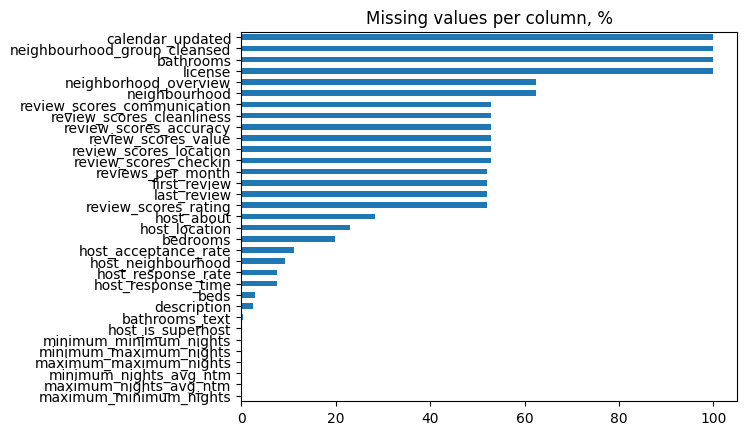

In [13]:
report_missing_value(listings)

In [14]:
df = preprocess_data(listings)

splitting the listing based on price range: [  78.   407.5 7425. ]


#### Model Building

In [15]:
# input and output variable 
target_vars = ["price", "price_label"]
use_feats = [col for col in df.columns if col not in target_vars]

#### Lasso Regression

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_absolute_error, r2_score

In [17]:
target = "price"
# Split data for evaluation
X_train, X_test, y_train, y_test = train_test_split(df[use_feats], df[target], random_state=SEED, test_size=.3)

In [18]:
def evaluate(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mae, r2 

In [19]:
# baseline model
from sklearn.dummy import DummyRegressor
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X_train, y_train)
evaluate(dummy_regr, X_test, y_test)

(486.7107770269043, -2.835480559881809e-05)

In [20]:
# Lasso regression model with standardization 
preprocessor = make_column_transformer(
    (StandardScaler(), use_feats),
)
lasso_pipeline = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=Lasso(alpha=1e-3), func=np.log10, inverse_func=exp10
    )
)
lasso_pipeline.fit(X_train, y_train)
evaluate(lasso_pipeline, X_test, y_test)

(279.9332102198158, 0.3297359956808025)

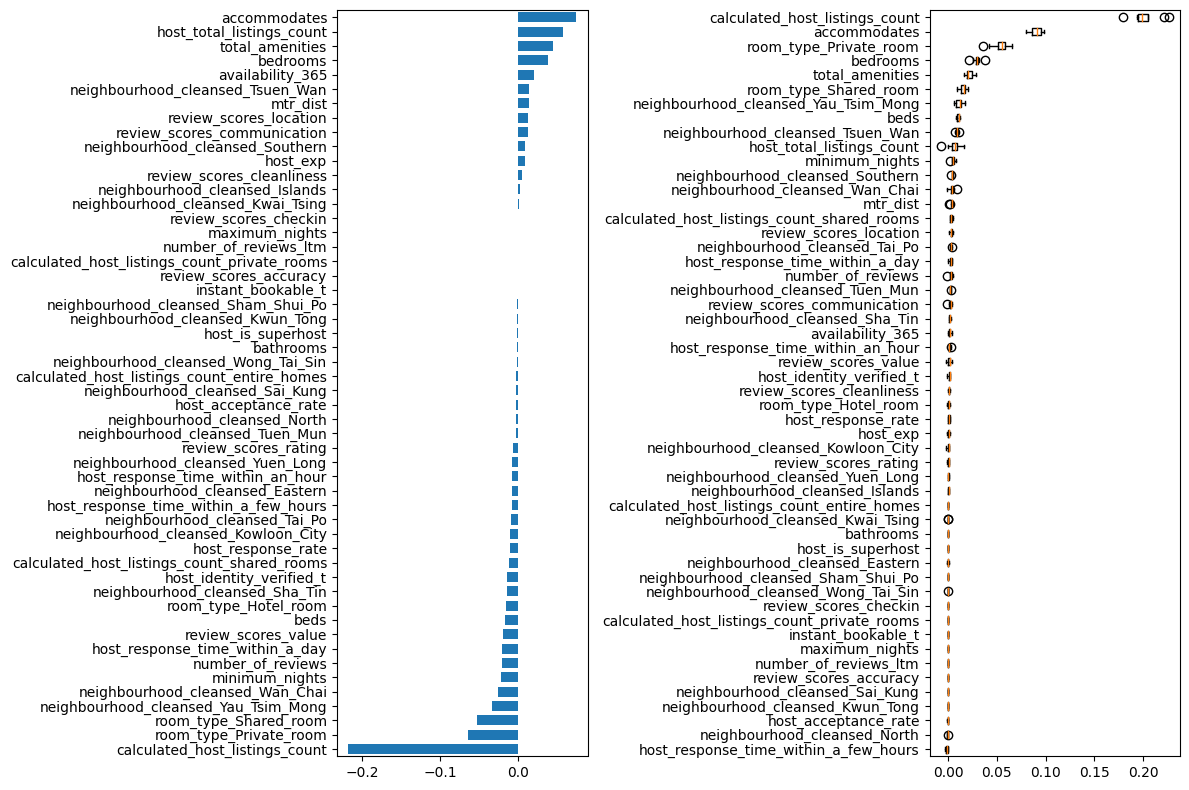

In [21]:
# Plot the feature importance with model coeff and permutation importance 
result = permutation_importance(lasso_pipeline, X_train, y_train, n_repeats=10, random_state=SEED)
perm_sorted_idx = result.importances_mean.argsort()

regr_lasso = lasso_pipeline[-1].regressor_
lasso_importance_sorted_idx = np.argsort(regr_lasso.coef_)
# Create some space between the tick 
lasso_indices = np.arange(0, len(regr_lasso.coef_)) + 0.5
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
ax1.barh(lasso_indices, regr_lasso.coef_[lasso_importance_sorted_idx], height=0.7)
ax1.set_yticks(lasso_indices)
ax1.set_yticklabels(X_train.columns[lasso_importance_sorted_idx])
ax1.set_ylim((0, len(regr_lasso.coef_)))
ax2.boxplot(
    result.importances[perm_sorted_idx].T,
    vert=False,
    labels=X_train.columns[perm_sorted_idx],
)
fig.tight_layout()
plt.show()

In [22]:
lasso_abs_importance_sorted_idx = np.argsort(np.abs(regr_lasso.coef_))
lasso_top10 = list(X_train.columns[lasso_abs_importance_sorted_idx[-10:]])
perm_top10 = list(X_train.columns[perm_sorted_idx[-10:]])
final_top = set(lasso_top10).intersection(set(perm_top10))

In [23]:
final_top

{'accommodates',
 'bedrooms',
 'calculated_host_listings_count',
 'host_total_listings_count',
 'neighbourhood_cleansed_Yau_Tsim_Mong',
 'room_type_Private_room',
 'room_type_Shared_room',
 'total_amenities'}

#### Random Forest Regression

In [24]:
rf_regr = RandomForestRegressor(n_estimators = 100, random_state=SEED)
rf_regr.fit(X_train, y_train)
evaluate(rf_regr, X_test, y_test)

(252.1413628367847, 0.5357023225844249)

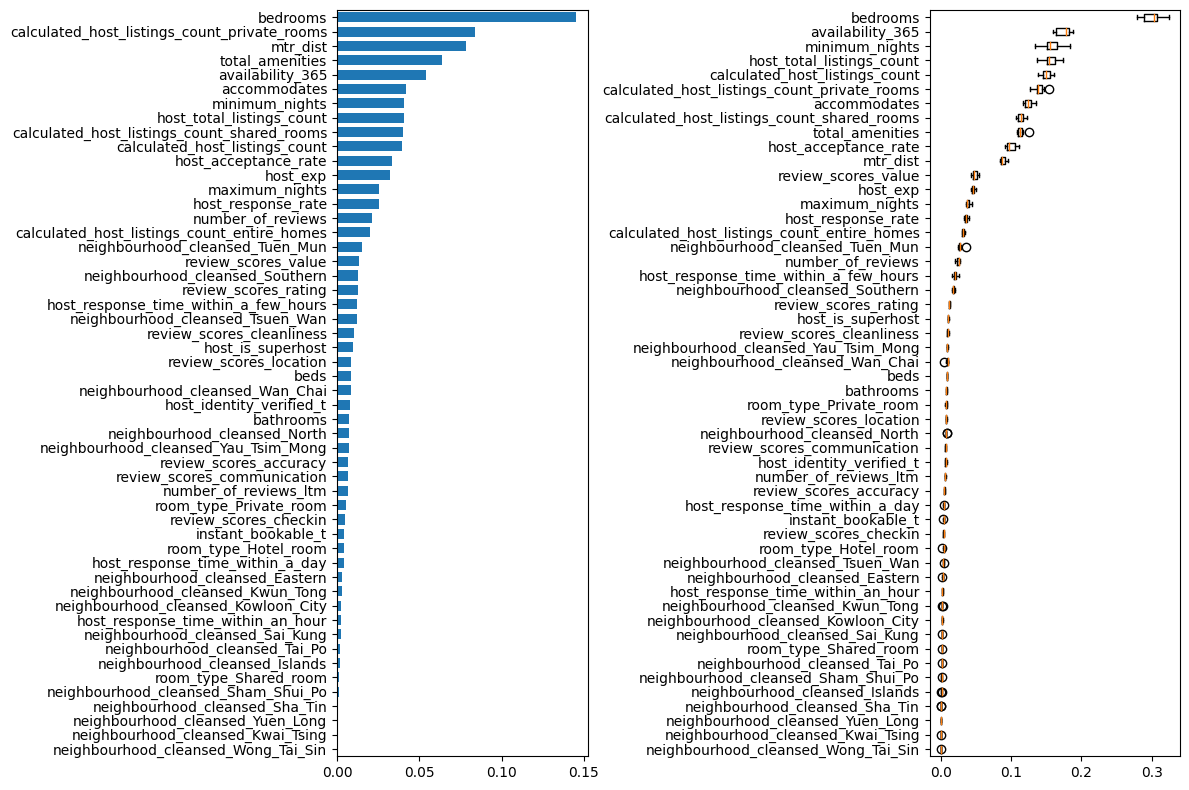

In [25]:
# Plot the feature importance with model impurity score and permutation importance 
result = permutation_importance(rf_regr, X_train, y_train, n_repeats=10, random_state=SEED)
perm_sorted_idx = result.importances_mean.argsort()

rf_importance_sorted_idx = np.argsort(rf_regr.feature_importances_)
# Create some space between the tick 
rf_indices = np.arange(0, len(rf_regr.feature_importances_)) + 0.5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
ax1.barh(rf_indices, rf_regr.feature_importances_[rf_importance_sorted_idx], height=0.7)
ax1.set_yticks(rf_indices)
ax1.set_yticklabels(X_train.columns[rf_importance_sorted_idx])
ax1.set_ylim((0, len(rf_regr.feature_importances_)))
ax2.boxplot(
    result.importances[perm_sorted_idx].T,
    vert=False,
    labels=X_train.columns[perm_sorted_idx],
)
fig.tight_layout()
plt.show()

In [26]:
rf_top10 = list(X_train.columns[rf_importance_sorted_idx[-10:]])
perm_top10 = list(X_train.columns[perm_sorted_idx[-10:]])
final_top = set(rf_top10).intersection(set(perm_top10))

In [27]:
final_top

{'accommodates',
 'availability_365',
 'bedrooms',
 'calculated_host_listings_count',
 'calculated_host_listings_count_private_rooms',
 'calculated_host_listings_count_shared_rooms',
 'host_total_listings_count',
 'minimum_nights',
 'total_amenities'}

#### Adding distance variable


In [28]:
#%pip install requests

In [29]:
import requests
import pandas as pd 
from typing import Iterable 
from bs4 import BeautifulSoup

In [30]:
def flatten(items):
    """Yield items from any nested iterable"""
    for x in items:
        if isinstance(x, Iterable) and not isinstance(x, (str, bytes)):
            for sub_x in flatten(x):
                yield sub_x
        else:
            if x is not None:
                yield x
                
def get_precision(f1):
    str1=str(f1)
    return len(str1.split(".")[1])

def get_mtr_location(q: str)->tuple[float, float]:
    # In order to get the mtr location, we try to make request on google map api
    # and try to get back the reponse with mtr lat/ long information
    try:
        link = "https://www.google.com/search?tbm=map&q=MTR%{}%20Station"
        r = requests.get(link.format(q))
        # Clean the text string and typecast as list 
        #print(r.text[5:])
        result_lst = eval(r.text[5:].replace("null", "None"))
        check_condit = lambda item: 1 if isinstance(item, float) and get_precision(item)>5 \
            and round(item) in [21, 22, 23, 113, 114, 115] else 0
        # Flatten the list and filter anything that is not like lat, long infomartion
        mtr_lat, mtr_long  = sorted([item for item in flatten(result_lst) if check_condit(item)][:2])

    except Exception as e:
        print(e)
        return None, None
        
    return mtr_lat, mtr_long 

In [31]:
# # Get the station list from hk mtr website 
# r = requests.get("https://www.mtr.com.hk/en/customer/services/system_map.html")
# soup = BeautifulSoup(r.text)

In [32]:
# mtr_list = []
# for tb in soup.find_all("table"):
#     mtr_list.extend(
#         [tr.findChild("td").text for tr in tb.findChildren("tr") if tr.findChild("td") is not None]
#     )
# # Remove duplicate 
# mtr_list = set(mtr_list)
# assert len(mtr_list) == 98

In [33]:
# tmp = []
# for station_name in mtr_list:
#      mtr_lat, mtr_long = get_mtr_location(station_name)
#      tmp.append([station_name, mtr_lat, mtr_long])
# result = pd.DataFrame(tmp, columns = ["station_name", "mtr_lat", "mtr_long"])
# result.to_csv("mtr-location.csv", index=False)

,mtr_dist,price
mtr_dist,1.000000,0.152261
price,0.152261,1.000000


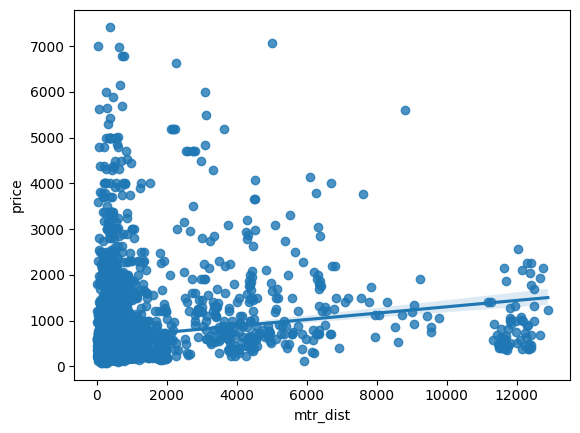

In [34]:
# are ther any relation between dist and price?
sns.regplot(data= df, x="mtr_dist", y="price")
df[["mtr_dist", "price"]].corr()

#### Feature Selection 
- We get different feature importance from linear regression and random forest model
- Can do better by removing the correlated feature 
- The idea is to first do hierarchical clustering for the feature corelation score 
- Then select one of the feature from each cluster 


In [35]:
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from collections import defaultdict

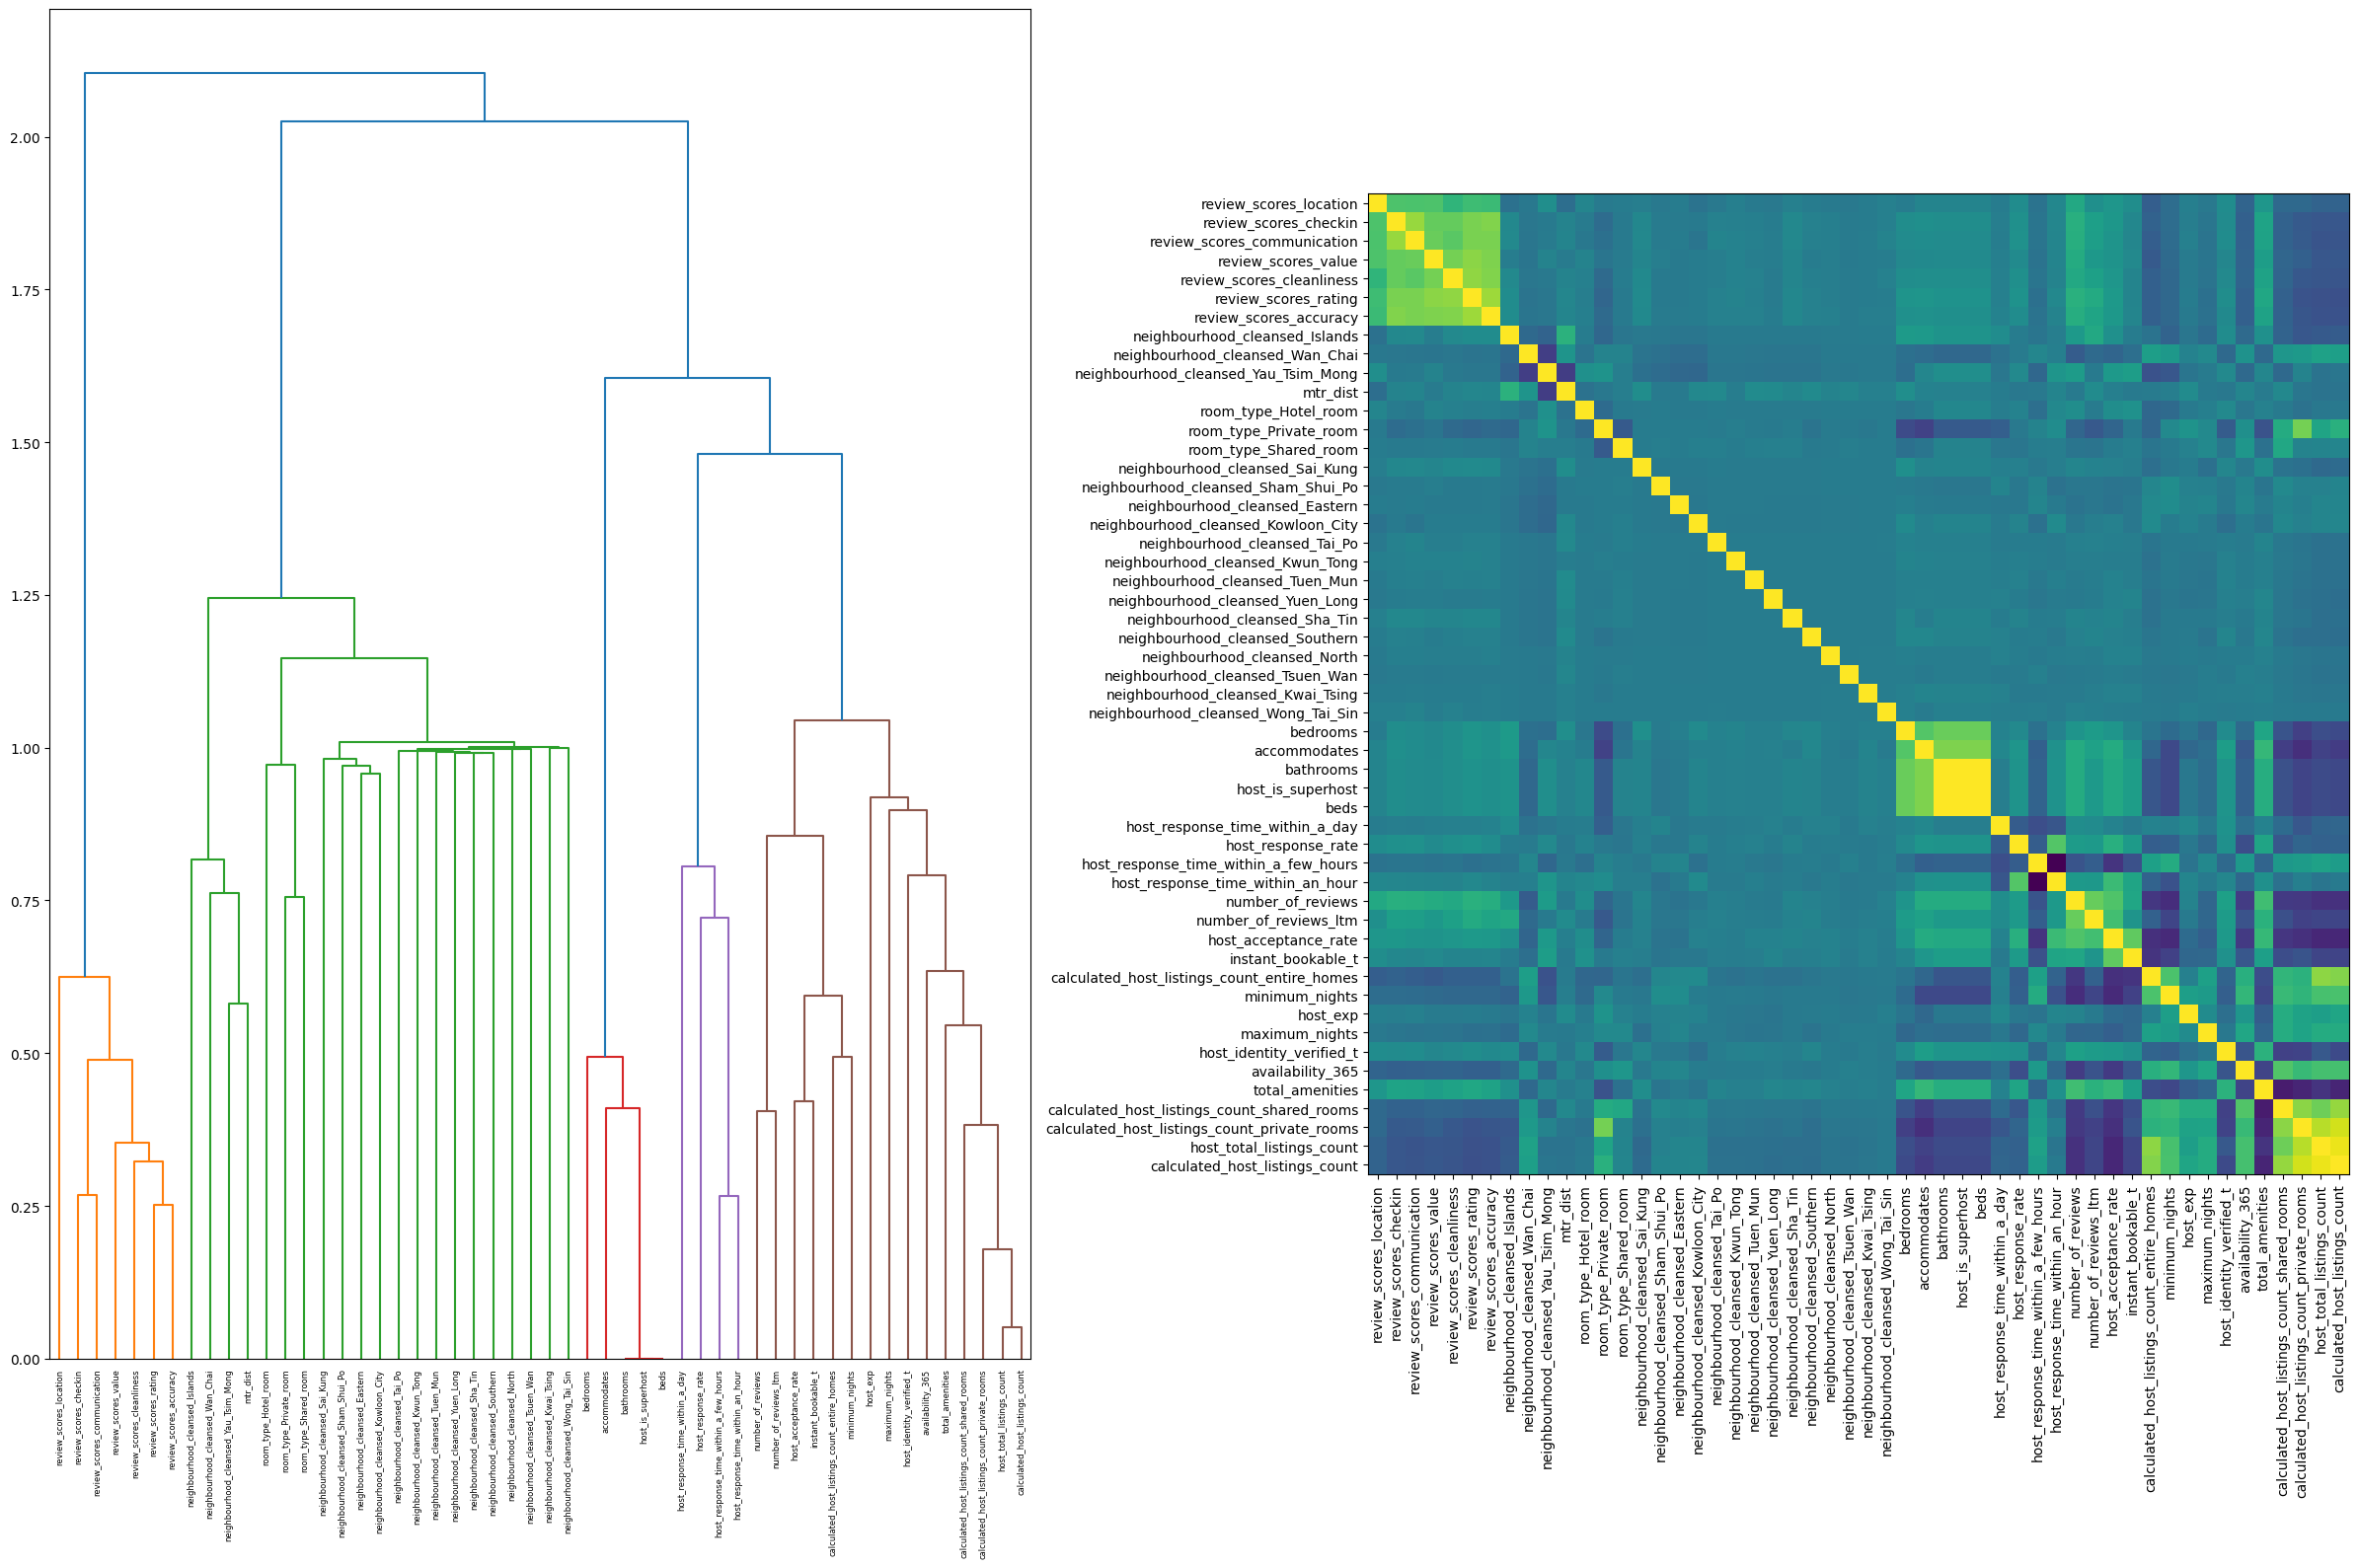

In [36]:
# hierarchical clustering using spearman ranking score 

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 16))
corr = spearmanr(df[use_feats]).correlation

# Ensure the correlation matrix is symmetric
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

# We convert the correlation matrix to a distance matrix before performing
# hierarchical clustering using Ward's linkage.
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(
    dist_linkage, labels=X_train.columns.tolist(), ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro["ivl"]))

ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro["ivl"], rotation="vertical")
ax2.set_yticklabels(dendro["ivl"])
fig.tight_layout()
plt.show()

In [37]:
# Select # of cluster based on distance threshold
cluster_ids = hierarchy.fcluster(dist_linkage, .75, criterion="distance")
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)

selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]
X_train_sel = X_train.iloc[:, selected_features]
X_test_sel = X_test.iloc[:, selected_features]

#### Retraining Random Forest 

In [38]:
rf_regr_sel = RandomForestRegressor(n_estimators=100, random_state=SEED)
rf_regr_sel.fit(X_train_sel, y_train)
evaluate(rf_regr_sel, X_test_sel, y_test)

(278.2658371700842, 0.468603643204453)

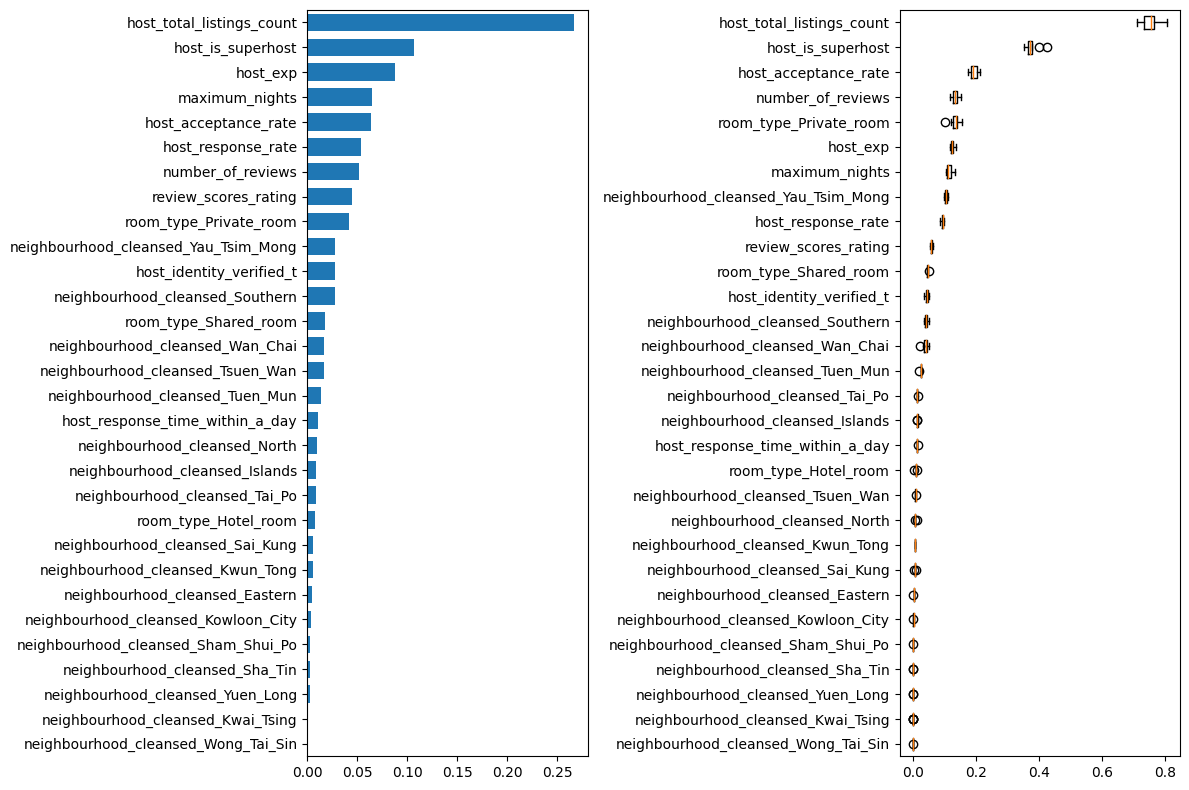

In [39]:
# Plot the feature importance with model impurity score and permutation importance 
result = permutation_importance(rf_regr_sel, X_train_sel, y_train, n_repeats=10, random_state=SEED)
perm_sorted_idx = result.importances_mean.argsort()

rf_importance_sorted_idx = np.argsort(rf_regr_sel.feature_importances_)
# Create some space between the tick 
rf_indices = np.arange(0, len(rf_regr_sel.feature_importances_)) + 0.5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
ax1.barh(rf_indices, rf_regr_sel.feature_importances_[rf_importance_sorted_idx], height=0.7)
ax1.set_yticks(rf_indices)
ax1.set_yticklabels(X_train_sel.columns[rf_importance_sorted_idx])
ax1.set_ylim((0, len(rf_regr_sel.feature_importances_)))
ax2.boxplot(
    result.importances[perm_sorted_idx].T,
    vert=False,
    labels=X_train_sel.columns[perm_sorted_idx],
)
fig.tight_layout()
plt.show()

In [40]:
rf_top10 = list(X_train_sel.columns[rf_importance_sorted_idx[-10:]])
perm_top10 = list(X_train_sel.columns[perm_sorted_idx[-10:]])
final_top = set(rf_top10).intersection(set(perm_top10))

In [41]:
final_top

{'host_acceptance_rate',
 'host_exp',
 'host_is_superhost',
 'host_response_rate',
 'host_total_listings_count',
 'maximum_nights',
 'neighbourhood_cleansed_Yau_Tsim_Mong',
 'number_of_reviews',
 'review_scores_rating',
 'room_type_Private_room'}

#### Retraining Lasso Regression

In [42]:
# Lasso regression model with standardization 
preprocessor = make_column_transformer(
    (StandardScaler(), X_train.columns[selected_features]),
)
lasso_pipeline_sel = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=Lasso(alpha=1e-3), func=np.log10, inverse_func=exp10
    )
)
lasso_pipeline_sel.fit(X_train_sel, y_train)
evaluate(lasso_pipeline_sel, X_test_sel, y_test)

(322.10384502998266, 0.22832077811182827)

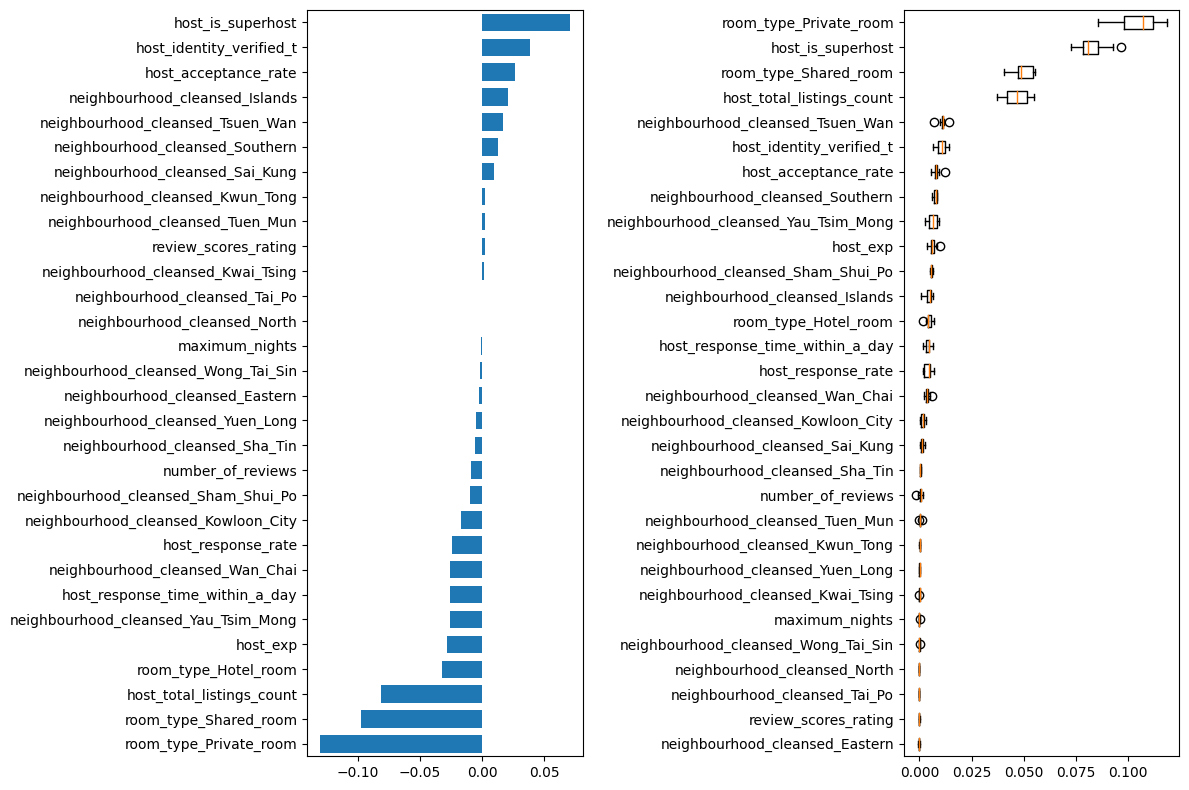

In [43]:
# Plot the feature importance with model coeff and permutation importance 
result = permutation_importance(lasso_pipeline_sel, X_train_sel, y_train, n_repeats=10, random_state=SEED)
perm_sorted_idx = result.importances_mean.argsort()

regr_lasso_sel = lasso_pipeline_sel[-1].regressor_
lasso_importance_sorted_idx = np.argsort(regr_lasso_sel.coef_)
# Create some space between the tick 
lasso_indices = np.arange(0, len(regr_lasso_sel.coef_)) + 0.5
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
ax1.barh(lasso_indices, regr_lasso_sel.coef_[lasso_importance_sorted_idx], height=0.7)
ax1.set_yticks(lasso_indices)
ax1.set_yticklabels(X_train_sel.columns[lasso_importance_sorted_idx])
ax1.set_ylim((0, len(regr_lasso_sel.coef_)))
ax2.boxplot(
    result.importances[perm_sorted_idx].T,
    vert=False,
    labels=X_train_sel.columns[perm_sorted_idx],
)
fig.tight_layout()
plt.show()

In [44]:
lasso_abs_importance_sorted_idx = np.argsort(np.abs(regr_lasso_sel.coef_))
lasso_top10 = list(X_train_sel.columns[lasso_abs_importance_sorted_idx[-10:]])
perm_top10 = list(X_train_sel.columns[perm_sorted_idx[-10:]])
final_top = set(lasso_top10).intersection(set(perm_top10))

In [45]:
lasso_top10

['host_response_time_within_a_day',
 'neighbourhood_cleansed_Yau_Tsim_Mong',
 'host_acceptance_rate',
 'host_exp',
 'room_type_Hotel_room',
 'host_identity_verified_t',
 'host_is_superhost',
 'host_total_listings_count',
 'room_type_Shared_room',
 'room_type_Private_room']

#### Observation/ Conclusion